In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math
import re

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import CatalogCalculationTask

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

In [2]:
# List of visits to be considered
#visits = [8]
#visits = [849375, 850587]
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal_2/"
# Reference visit
ref = 802227

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
#ccd = [0, 1, 7, 8, 27, 28, 33, 35]
ccd = range(0,36)
#ccd = [21, 22, 27, 28]
#ccd = [14]
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler(DATADIR+"/jointcal_comp_12days")
butlerV = dafPersist.Butler(DATADIR+"/vanilla_12days")

In [3]:
def detect_sources(exposure):
    threshold = 6
    doSmooth=True
    schema = afwTable.SourceTable.makeMinimalSchema()


    algMetadata = dafBase.PropertyList()

    config = SourceDetectionTask.ConfigClass()
    #config.thresholdPolarity = "both"
    config.thresholdValue = threshold
    config.reEstimateBackground = False
    #config.thresholdType = "pixel_stdev"

    detectionTask = SourceDetectionTask(config=config, schema=schema)

    measurement = SingleFrameMeasurementTask
    config = measurement.ConfigClass()

    measurement = measurement(schema, config=config, algMetadata=algMetadata)

    deblend = SourceDeblendTask
    config = SourceDeblendTask.ConfigClass()
    deblend = deblend(schema)

    calculation = CatalogCalculationTask
    config = CatalogCalculationTask.ConfigClass()
    config.plugins.names.clear()
    config.plugins.names.add("base_ClassificationExtendedness")

    calculation = calculation(schema, config=config)

    table = afwTable.SourceTable.make(schema)

    results = detectionTask.run(table=table, exposure=exposure , doSmooth=doSmooth )

    sourcesCat = results.sources
    print "deblending"
    deblend.run(exposure, sourcesCat)
    print "measuring"
    measurement.run(measCat=sourcesCat, exposure=exposure)
    print "calculating"
    calculation.run(sourcesCat)
    return sourcesCat


In [14]:
for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    dataid2 = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':0}
    if butler.datasetExists('src', dataid):
    
        oldSrc = butler.get('src', dataid, immediate=True)
        newWcs = butler.get("wcs", dataid2).getWcs()
        calexp = butler.get("calexp_md", dataid)
        oldWcs = afwImage.makeWcs(calexp)
        
        
        print c, len(oldSrc)
            
       
        
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type="I", doc="CCD number")

            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)

        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

0 2670
1 3119
2 3419
3 3094
4 3215
5 3425
6 2980
7 3209
8 2918
9 3406
10 3073
11 3077
12 2809
13 2822
14 3033
15 3513
16 3178
17 2560
18 2985
19 2849
20 2965
21 2843
22 3007
23 3075
24 2908
25 2824
26 2681
27 2692
28 2957
29 2738
30 2979
31 3207
32 2904
33 3213
34 2970
35 2924
Ref... 108241


In [3]:
for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    dataid2 = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':0}
    if butler.datasetExists('src', dataid):
    
        oldSrc = butler.get('src', dataid, immediate=True)
        newWcs = butler.get("wcs", dataid2).getWcs()
        calexp = butler.get("calexp_md", dataid)
        oldWcs = afwImage.makeWcs(calexp)
        
        
        print c, len(oldSrc)
            
            
        for s in oldSrc:

            coord = s.getCoord()
            pix = oldWcs.skyToPixel(coord.getRa(), coord.getDec())
            newCoord = newWcs.pixelToSky(pix).toIcrs()
            s.setCoord(newCoord)
            
         

        
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type="I", doc="CCD number")

            #create the new extented source catalog 
            jointcal_srcRef = afwTable.SourceCatalog(newSchema)

        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(jointcal_srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        jointcal_srcRef.extend(tmpCat, deep=False)

print "Ref...", len(jointcal_srcRef)

0 2670
1 3119
2 3419
3 3094
4 3215
5 3425
6 2980
7 3209
8 2918
9 3406
10 3073
11 3077
12 2809
13 2822
14 3033
15 3513
16 3178
17 2560
18 2985
19 2849
20 2965
21 2843
22 3007
23 3075
24 2908
25 2824
26 2681
27 2692
28 2957
29 2738
30 2979
31 3207
32 2904
33 3213
34 2970
35 2924
Ref... 108241


In [29]:
s.getCoord()

IcrsCoord(214.13981297724064*afwGeom.degrees, 52.41496650080333*afwGeom.degrees)

In [32]:
s.getCoord()

IcrsCoord(214.13980012842234*afwGeom.degrees, 52.414984477059264*afwGeom.degrees)

In [38]:
srcRef[-1].getCoord()

IcrsCoord(214.13980012842234*afwGeom.degrees, 52.414984477059264*afwGeom.degrees)

In [18]:
schema = srcRef.getSchema()
ccdKeyRef = schema["ccd"].asKey()
fluxKey = schema["base_CircularApertureFlux_4_5_flux"].asKey()
print ccdKeyRef

Key<I>(offset=496, nElements=1)


In [5]:
print len(patches)

504


In [6]:
patches[len(patches)-7]

'23,18'

In [113]:
jointcal_dccat_comp = afwTable.SourceCatalog.readFits(DATADIR+"/jointcal_comp_3days.fits")
jointcal_dccat_ind = afwTable.SourceCatalog.readFits(DATADIR+"/jointcal_ind_3days.fits")


In [91]:
print len(jointcalday_dccat_comp), len(jointcalday_dccat_ind),len(vanilla_dccat)

226674 226674 202223


In [21]:
distances_vanilla = []
for i, m in enumerate(matches_vanilla):
    mref = m.first
    mvanilla = m.second
      
    if i%1000==0:
        print "here", i
    
    
    dataRef={'visit':ref, 'filter':"r", 'ccd':mref.get(ccdKeyRef)}
    
    mdRef = butler.get("calexp_md", dataRef, immediate=True)
    calib = afwImage.Calib(mdRef)
    flux = mref.get(fluxKey)
    if flux > 0. :
            refMag = calib.getMagnitude(flux)
            
    
    
    if mvanilla["base_ClassificationExtendedness_value"]>0.5 and refMag > 16.5 and refMag < 22:
    
        distances_vanilla.append(afwGeom.radToMas(m.distance))

here 0
here 1000
here 2000
here 3000
here 4000
here 5000
here 6000
here 7000
here 8000
here 9000
here 10000
here 11000
here 12000
here 13000
here 14000
here 15000
here 16000
here 17000
here 18000
here 19000
here 20000
here 21000
here 22000
here 23000
here 24000
here 25000
here 26000
here 27000
here 28000
here 29000
here 30000
here 31000
here 32000
here 33000
here 34000
here 35000
here 36000
here 37000
here 38000
here 39000
here 40000
here 41000
here 42000
here 43000
here 44000
here 45000
here 46000
here 47000
here 48000
here 49000
here 50000
here 51000
here 52000
here 53000
here 54000
here 55000
here 56000
here 57000
here 58000
here 59000
here 60000
here 61000
here 62000
here 63000
here 64000
here 65000
here 66000
here 67000
here 68000
here 69000
here 70000
here 71000
here 72000
here 73000
here 74000
here 75000
here 76000
here 77000
here 78000
here 79000
here 80000
here 81000
here 82000
here 83000


In [58]:
 dataRef={'visit':ref, 'filter':"r", 'ccd':mref.get(ccdKeyRef)}
    
mdRef = butler.get("calexp_md", dataRef, immediate=True)
calib = afwImage.Calib(mdRef)
flux = mref.get(fluxKey)
if flux > 0. :
        refMag = calib.getMagnitude(flux)
        print refMag

21.5940423385


In [59]:
print len(matches_jointcal_comp)

80894


In [25]:
jointcalday_dccat_comp = afwTable.SourceCatalog.readFits(DATADIR+"/jointcal_comp_3days.fits")
jointcalday_dccat_ind = afwTable.SourceCatalog.readFits(DATADIR+"/jointcal_ind_3days.fits")
vanilla_dccat = afwTable.SourceCatalog.readFits(DATADIR+"/extended_vanilla_12days.fits")

In [ ]:
matches_dayjointcal_comp = afwTable.matchRaDec(jointcal_srcRef, jointcalday_dccat_comp, afwGeom.Angle(1./3600., afwGeom.degrees))
matches_dayjointcal_ind = afwTable.matchRaDec(jointcal_srcRef, jointcalday_dccat_ind, afwGeom.Angle(1./3600., afwGeom.degrees))
matches_vanilla = afwTable.matchRaDec(srcRef, vanilla_dccat, afwGeom.Angle(1./3600., afwGeom.degrees))

In [ ]:
def getDistances(catalog1, catalog2):
    matches = afwTable.matchRaDec(catalog1, catalog2, afwGeom.Angle(1./3600., afwGeom.degrees))
    distances = []
    for i, m in enumerate(matches):
        mref = m.first
        mjoint = m.second

        if i%1000==0:
            print "here", i


        #dataRef={'visit':ref, 'filter':"r", 'ccd':mref.get(ccdKeyRef)}

        #mdRef = butler.get("calexp_md", dataRef, immediate=True)
        #calib = afwImage.Calib(mdRef)
        #flux = mref.get(fluxKey)
        #if flux > 0. :
        #        refMag = calib.getMagnitude(flux)
        refMag= 20


        if mjoint["base_ClassificationExtendedness_value"]>0.5 and refMag > 16.5 and refMag<22:
            distances.append(afwGeom.radToMas(m.distance))
    return distances

In [29]:
distances_dayjoint_comp = getDistances(jointcal_srcRef, jointcalday_dccat_comp)
distances_dayjoint_ind = getDistances(jointcal_srcRef, jointcalday_dccat_ind)

here 0
here 1000
here 2000
here 3000
here 4000
here 5000
here 6000
here 7000
here 8000
here 9000
here 10000
here 11000
here 12000
here 13000
here 14000
here 15000
here 16000
here 17000
here 18000
here 19000
here 20000
here 21000
here 22000
here 23000
here 24000
here 25000
here 26000
here 27000
here 28000
here 29000
here 30000
here 31000
here 32000
here 33000
here 34000
here 35000
here 36000
here 37000
here 38000
here 39000
here 40000
here 41000
here 42000
here 43000
here 44000
here 45000
here 46000
here 47000
here 48000
here 49000
here 50000
here 51000
here 52000
here 53000
here 54000
here 55000
here 56000
here 57000
here 58000
here 59000
here 60000
here 61000
here 62000
here 63000
here 64000
here 65000
here 66000
here 67000
here 68000
here 69000
here 70000
here 71000
here 72000
here 73000
here 74000
here 75000
here 76000
here 77000
here 78000
here 79000
here 80000
here 81000
here 82000
here 83000
here 84000
here 85000
here 86000
here 87000
here 88000
here 89000
here 90000
here 91000
h

In [30]:
len(distances_dayjoint_comp), len(distances_dayjoint_ind)

(62486, 62486)

NameError: name 'distances_joint_comp' is not defined

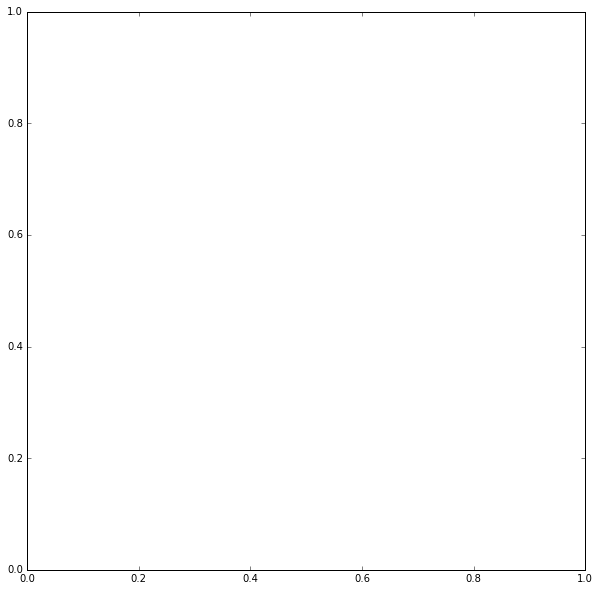

In [28]:
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(distances_joint_comp, bins=200, histtype="step", label="Coadd with jointcal", color="blue")
ax0.hist(distances_joint_ind, bins=200, histtype="step", label="Coadd with jointcal", color="green")
ax0.hist(distances_vanilla, bins=200, histtype="step", label="Coadd without jointcal", color="red")

ax0.legend()
ax0.set_xlim([0,300])
#ax0.text("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),(0.4,0.8), xycoords="figure fraction")
ax0.text(0.4, 0.5,"Median scatter  : %0.1f mas"%( np.median(distances_joint_comp)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='blue',)
ax0.text(0.4, 0.55,"Median scatter  : %0.1f mas"%( np.median(distances_joint_ind)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='green',)
ax0.text(0.4, 0.6,"Median scatter : %0.1f mas"%( np.median(distances_vanilla)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='red',)

ax0.set_xlabel("angular distance in mas")
ax0.set_ylabel("# of sources")

plt.show()

#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))
#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))


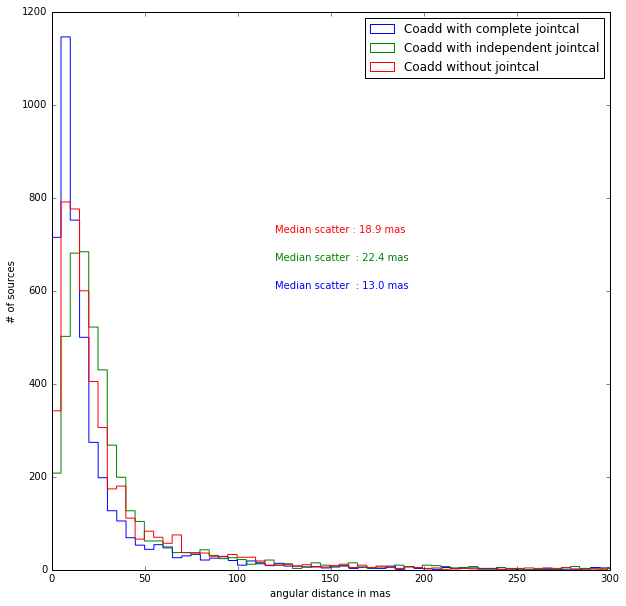

In [121]:
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(distances_joint_comp, bins=200, histtype="step", label="Coadd with complete jointcal", color="blue")
ax0.hist(distances_joint_ind, bins=200, histtype="step", label="Coadd with independent jointcal", color="green")
ax0.hist(distances_vanilla, bins=200, histtype="step", label="Coadd without jointcal", color="red")

ax0.legend()
ax0.set_xlim([0,300])
#ax0.text("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),(0.4,0.8), xycoords="figure fraction")
ax0.text(0.4, 0.5,"Median scatter  : %0.1f mas"%( np.median(distances_joint_comp)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='blue',)
ax0.text(0.4, 0.55,"Median scatter  : %0.1f mas"%( np.median(distances_joint_ind)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='green',)
ax0.text(0.4, 0.6,"Median scatter : %0.1f mas"%( np.median(distances_vanilla)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='red',)

ax0.set_xlabel("angular distance in mas")
ax0.set_ylabel("# of sources")

plt.show()

#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))
#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))


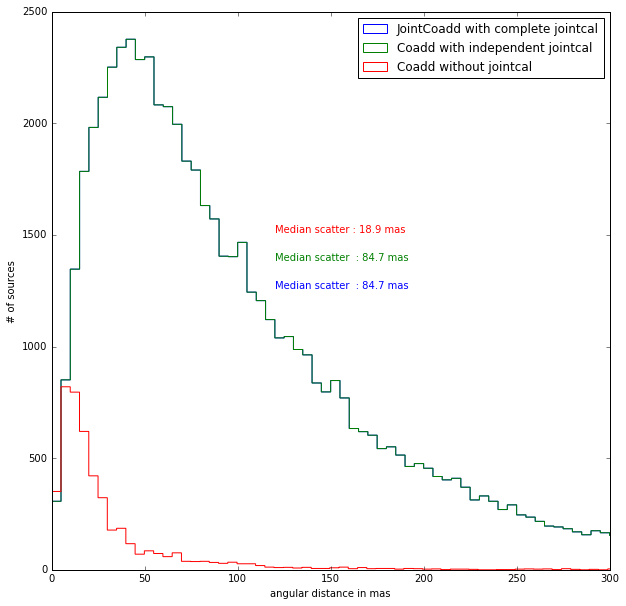

In [31]:
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(distances_dayjoint_comp, bins=200, histtype="step", label="JointCoadd with complete jointcal", color="blue")
ax0.hist(distances_dayjoint_ind, bins=200, histtype="step", label="Coadd with independent jointcal", color="green")
ax0.hist(distances_vanilla, bins=200, histtype="step", label="Coadd without jointcal", color="red")

ax0.legend()
ax0.set_xlim([0,300])
#ax0.text("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),(0.4,0.8), xycoords="figure fraction")
ax0.text(0.4, 0.5,"Median scatter  : %0.1f mas"%( np.median(distances_dayjoint_comp)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='blue',)
ax0.text(0.4, 0.55,"Median scatter  : %0.1f mas"%( np.median(distances_dayjoint_ind)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='green',)
ax0.text(0.4, 0.6,"Median scatter : %0.1f mas"%( np.median(distances_vanilla)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='red',)

ax0.set_xlabel("angular distance in mas")
ax0.set_ylabel("# of sources")

plt.show()


In [32]:
butler

Butler(datasetTypeAliasDict={}, repos=RepoDataContainer(
byRepoRoot={'/datadec/cppm/jpreyes/CFHT_MPI/input_testSN': RepoData(args=RepositoryArgs(root='/datadec/cppm/jpreyes/CFHT_MPI/input_testSN', cfgRoot='/datadec/cppm/jpreyes/CFHT_MPI/input_testSN', mapper=<class 'lsst.obs.cfht.megacamMapper.MegacamMapper'>, mapperArgs=None, tags=set([]), mode='r', policy=None) cfg=RepositoryCfg(root='/datadec/cppm/jpreyes/CFHT_MPI/input_testSN', mapper=<class 'lsst.obs.cfht.megacamMapper.MegacamMapper'>, mapperArgs=None, parents=[], policy=None) repo=<lsst.daf.persistence.repository.Repository object at 0x7f4578197250> tags=set([]) isNewRepository=False isV1Repository:True parentRegistry:None), '/datadec/cppm/jpreyes/CFHT_Jointcal_2//jointcal_comp_12days': RepoData(args=RepositoryArgs(root='/datadec/cppm/jpreyes/CFHT_Jointcal_2//jointcal_comp_12days', cfgRoot=None, mapper=None, mapperArgs={}, tags=set([]), mode='rw', policy=None) cfg=RepositoryCfg(root='/datadec/cppm/jpreyes/CFHT_Jointcal_2//jointca

In [34]:
butler = dafPersist.Butler(DATADIR+"/jointcal_comp_12days")


AttributeError: 'Butler' object has no attribute '_getParentRepoDatast'

In [36]:
butler._getParentRepoDatas()

TypeError: _getParentRepoDatas() takes exactly 2 arguments (1 given)

In [39]:
dataId = {'patch':"23,18", 'filter':filter, 'tract':0, "date":"2006-04-30"}
butler._locate("dayCoadd", dataId, False)

AttributeError: 'dict' object has no attribute 'tag'